In [ ]:
!pip uninstall pyarrow -y
!pip uninstall datasets -y
!pip install pyarrow==10.0.1 datasets==2.4.0
!pip install transformers nltk

Found existing installation: pyarrow 10.0.1
Uninstalling pyarrow-10.0.1:
  Successfully uninstalled pyarrow-10.0.1
Found existing installation: datasets 2.4.0
Uninstalling datasets-2.4.0:
  Successfully uninstalled datasets-2.4.0
  Using cached pyarrow-10.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.9 MB)
  Using cached datasets-2.4.0-py3-none-any.whl (365 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 10.0.1 which is incompatible.


In [ ]:
!git clone https://github.com/ryanzhumich/AESLC

fatal: destination path 'AESLC' already exists and is not an empty directory.


In [ ]:
import os
import pandas as pd

In [ ]:
def load_data_from_directory(directory):
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".subject"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    subject = f.readline().strip()
                    email_body = f.read().strip()
                    data.append({'subject_line': subject, 'email_body': email_body})
    return pd.DataFrame(data)

train_data = load_data_from_directory('/content/AESLC/enron_subject_line/train')
dev_data = load_data_from_directory('/content/AESLC/enron_subject_line/dev')
test_data = load_data_from_directory('/content/AESLC/enron_subject_line/test')

In [ ]:
train_data.head()

,subject_line,email_body
0,Sam: We need to send Sharen Cason the Deemed ...,It is a domestic deal and I'd like to review y...
1,"Patrick, The attached file contains the base...",Let me know if you have any questions.\nD\n\n@...
2,FYI: One of our legal consultants has mentione...,They are using an outfit called Intuitive Pro...
3,"Marc, Here's a draft reply to your latest e-m...","What do you think?\nMarc, We have sought, and..."
4,"Richard, I would like to inform you that we ...",Thanks for your interest in having Enron invo...


In [ ]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-small')

def tokenize_data(data):
    inputs = [email for email in data['email_body']]
    targets = [subject for subject in data['subject_line']]
    tokenized_inputs = tokenizer(inputs, max_length=512, truncation=True, padding=True)
    tokenized_targets = tokenizer(targets, max_length=10, truncation=True, padding=True)
    return tokenized_inputs, tokenized_targets

train_inputs, train_targets = tokenize_data(train_data)
dev_inputs, dev_targets = tokenize_data(dev_data)
test_inputs, test_targets = tokenize_data(test_data)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

train_data['email_body'] = train_data['email_body'].apply(remove_stopwords)
dev_data['email_body'] = dev_data['email_body'].apply(remove_stopwords)
test_data['email_body'] = test_data['email_body'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('averaged_perceptron_tagger')

def pos_tagging(text):
    return nltk.pos_tag(text.split())

train_data['pos_tags'] = train_data['email_body'].apply(pos_tagging)
dev_data['pos_tags'] = dev_data['email_body'].apply(pos_tagging)
test_data['pos_tags'] = test_data['email_body'].apply(pos_tagging)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
def chunking(text):
    grammar = "NP: {<DT>?<JJ>*<NN>}"
    chunk_parser = nltk.RegexpParser(grammar)
    pos_tags = pos_tagging(text)
    return chunk_parser.parse(pos_tags)

train_data['chunks'] = train_data['email_body'].apply(chunking)
dev_data['chunks'] = dev_data['email_body'].apply(chunking)
test_data['chunks'] = test_data['email_body'].apply(chunking)


In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

train_data['email_body'] = train_data['email_body'].apply(lemmatize_text)
dev_data['email_body'] = dev_data['email_body'].apply(lemmatize_text)
test_data['email_body'] = test_data['email_body'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


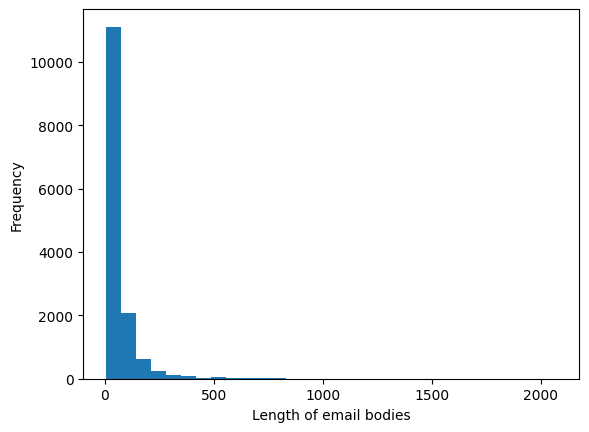

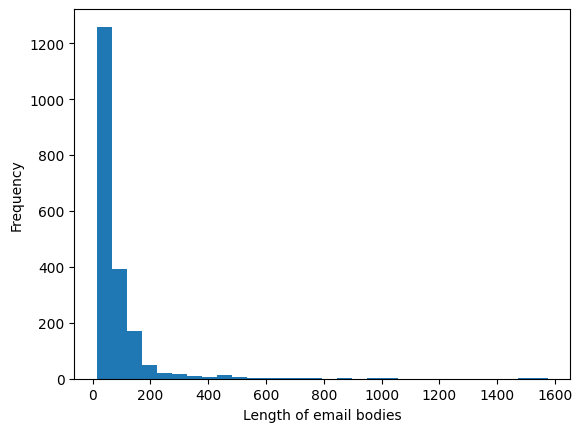

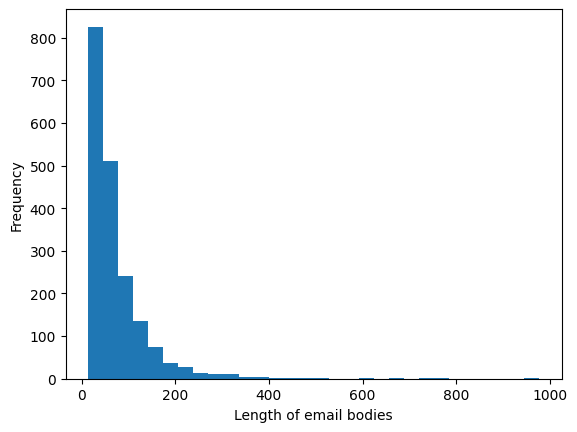

In [ ]:
import matplotlib.pyplot as plt

def plot_data(data):
    lengths = [len(text.split()) for text in data['email_body']]
    plt.hist(lengths, bins=30)
    plt.xlabel('Length of email bodies')
    plt.ylabel('Frequency')
    plt.show()

plot_data(train_data)
plot_data(dev_data)
plot_data(test_data)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np

class EmailDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, index):
        input_ids = self.inputs['input_ids'][index]
        attention_mask = self.inputs['attention_mask'][index]
        labels = self.targets['input_ids'][index]
        return {'input_ids': torch.tensor(input_ids), 'attention_mask': torch.tensor(attention_mask), 'labels': torch.tensor(labels)}

train_dataset = EmailDataset(train_inputs, train_targets)
dev_dataset = EmailDataset(dev_inputs, dev_targets)
test_dataset = EmailDataset(test_inputs, test_targets)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

model = T5ForConditionalGeneration.from_pretrained('t5-small')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    losses = []
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return np.mean(losses)

EPOCHS = 3
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    print(f'Train loss {train_loss}')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train loss 3.8656539733390067
Train loss 3.391702651185012
Train loss 3.2741939088314194


In [ ]:
!pip install datasets

In [ ]:
#!pip uninstall pyarrow -y
#!pip uninstall datasets -y
#!pip install pyarrow==10.0.1 datasets==2.4.0

In [ ]:
from datasets import load_metric

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    metric = load_metric("rouge")
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)

        preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
        refs = [tokenizer.decode(l, skip_special_tokens=True, clean_up_tokenization_spaces=True) for l in labels]

        metric.add_batch(predictions=preds, references=refs)

    final_score = metric.compute()
    return final_score

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=631c755b2500fd8c1c60c4496418ca6323a160a947196728397e0662c0209580
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
score = evaluate(model, test_loader, device)
print(score)

{'rouge1': AggregateScore(low=Score(precision=0.15546613451256672, recall=0.14808871108779292, fmeasure=0.14900938152926857), mid=Score(precision=0.16398049601092624, recall=0.15576999950032455, fmeasure=0.15685747899885955), high=Score(precision=0.17250533507386873, recall=0.16437575992271686, fmeasure=0.16505824539798197)), 'rouge2': AggregateScore(low=Score(precision=0.04154679146055068, recall=0.04044229063608656, fmeasure=0.04024834061822525), mid=Score(precision=0.04748757057912363, recall=0.04624712686753614, fmeasure=0.04608234178669654), high=Score(precision=0.05337872570329295, recall=0.05251456865537408, fmeasure=0.05211968677964231)), 'rougeL': AggregateScore(low=Score(precision=0.14823830655906953, recall=0.14119534802378428, fmeasure=0.14193445415825603), mid=Score(precision=0.157056975465947, recall=0.14957694165459104, fmeasure=0.1503565602795593), high=Score(precision=0.16510909575442603, recall=0.1575408068089073, fmeasure=0.1582190554226618)), 'rougeLsum': AggregateS

In [ ]:
sample_email = """
All: Attached you will find a list that reflects your seat assignments for Business Continuity Planning (BCP).
These seats are located on the 30th and 31st Floors of Enron Center North (ECN).
As previously communicated, you will report to these designated seats in the event of an outage in ECS.
The exception to this is as follows: If your seat assignment is located on the 31st Floor, you will report to your original location that you occupied prior to your move into ECS.
This will hold true until the Monday after Thanksgiving, as we will have the 31st floor seats set up at that time.
Testing: Once you have moved to ECS, if you would like to test your BCP location, you will be able to test your seat for functionality every Thursday from 3-6pm.
Testing is not required, but is highly recommended.
If anyone has any questions or concerns about these procedures, please feel free to contact me at any time.
Regards,

@subject
BCP Seat Assignments

@ann0
your seat assignments for business continuity planning (bcp).

@ann1
bcp seat assignments

@ann2
here are your seat assignments for the business continuity planning event
"""
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: Attached is a list of your


In [ ]:
sample_email = "Hi team, the project deadline has been extended to next Friday. Please ensure all deliverables are completed by then. Thanks."
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: Hi team, I have been working on


In [ ]:
sample_email = "Michelle;  This is the presentation which was provided to the HR VP's.The HR VPs were tasked with going off to met their BU OTCs and devise plans around the three components.We are currently collating those plans into one document.We'll send that along to you when completed.Pls call if you have any questions."
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: The HR VP's were assigned to


In [ ]:
sample_email = "To confirm:  Mark Thomas Mike Presley  both previously on the list for Netco's Market Risk/Research Group have resigned.I'm combing the Estate for replacements.DP"
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: Mark Thomas Mike Presley and Mark Thomas


In [ ]:
model.save_pretrained('./t5-email-subject-generator')
tokenizer.save_pretrained('./t5-email-subject-generator')

('./t5-email-subject-generator/tokenizer_config.json',
 './t5-email-subject-generator/special_tokens_map.json',
 './t5-email-subject-generator/spiece.model',
 './t5-email-subject-generator/added_tokens.json')